# 1. Load Correlation Matrices

In [1]:
import numpy as np
import os

# Directory where correlation matrices are saved
corr_dir = os.path.expanduser("~/correlation_matrices")

# Correlation types
correlation_types = ["correlation", "partial correlation", "tangent"]

# Dictionary to store loaded matrices
correlation_matrices = {}

# Load each correlation matrix file
for kind in correlation_types:
    file_path = os.path.join(corr_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


# 2. Extract Upper Triangle Features

In [2]:
# Get indices for the upper triangle without diagonal

#each correlation matrix is 39x39 (one per subject)
#shape[1] gets the second dimension, which is 39. (39 brain regions per subject)
n_nodes = correlation_matrices["correlation"].shape[1]

'''
For 39 nodes, that gives us 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).
'''
upper_idx = np.triu_indices(n_nodes, k=1)  # gets indices for upper triangle and k=1 excludes diagonal

# Function to extract upper triangles from a 3D matrix set
'''
Takes a set of correlation matrices 
For each subject, extracts just the upper triangle values
Returns an array of shape (155, 741) — one flattened feature vector per subject.
'''
def extract_upper_triangles(matrix_set):
    b = np.array([matrix[upper_idx] for matrix in matrix_set]) #np. array turns it into a 2d array 
    print(b.shape)
    return b 
# Dictionary to store upper triangle features
'''
Loops over each correlation type
Applies the function to extract the features
Stores the results in upper_triangle_features dict
'''
upper_triangle_features = {}

for kind in correlation_types:
    upper_triangle_features[kind] = extract_upper_triangles(correlation_matrices[kind])
    print(f"{kind} features shape: {upper_triangle_features[kind].shape}")


(155, 741)
correlation features shape: (155, 741)
(155, 741)
partial correlation features shape: (155, 741)
(155, 741)
tangent features shape: (155, 741)


# 3. Load Labels

In [3]:
import numpy as np
import os

# Define path to the labels file 
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Confirm it's correct
print("Labels shape:", labels.shape)
print("Unique labels and counts:", np.unique(labels, return_counts=True))


Labels shape: (155,)
Unique labels and counts: (array([0, 1]), array([122,  33]))


# 4. Initialize Linear SVC Classifier


🔍 Evaluating: CORRELATION


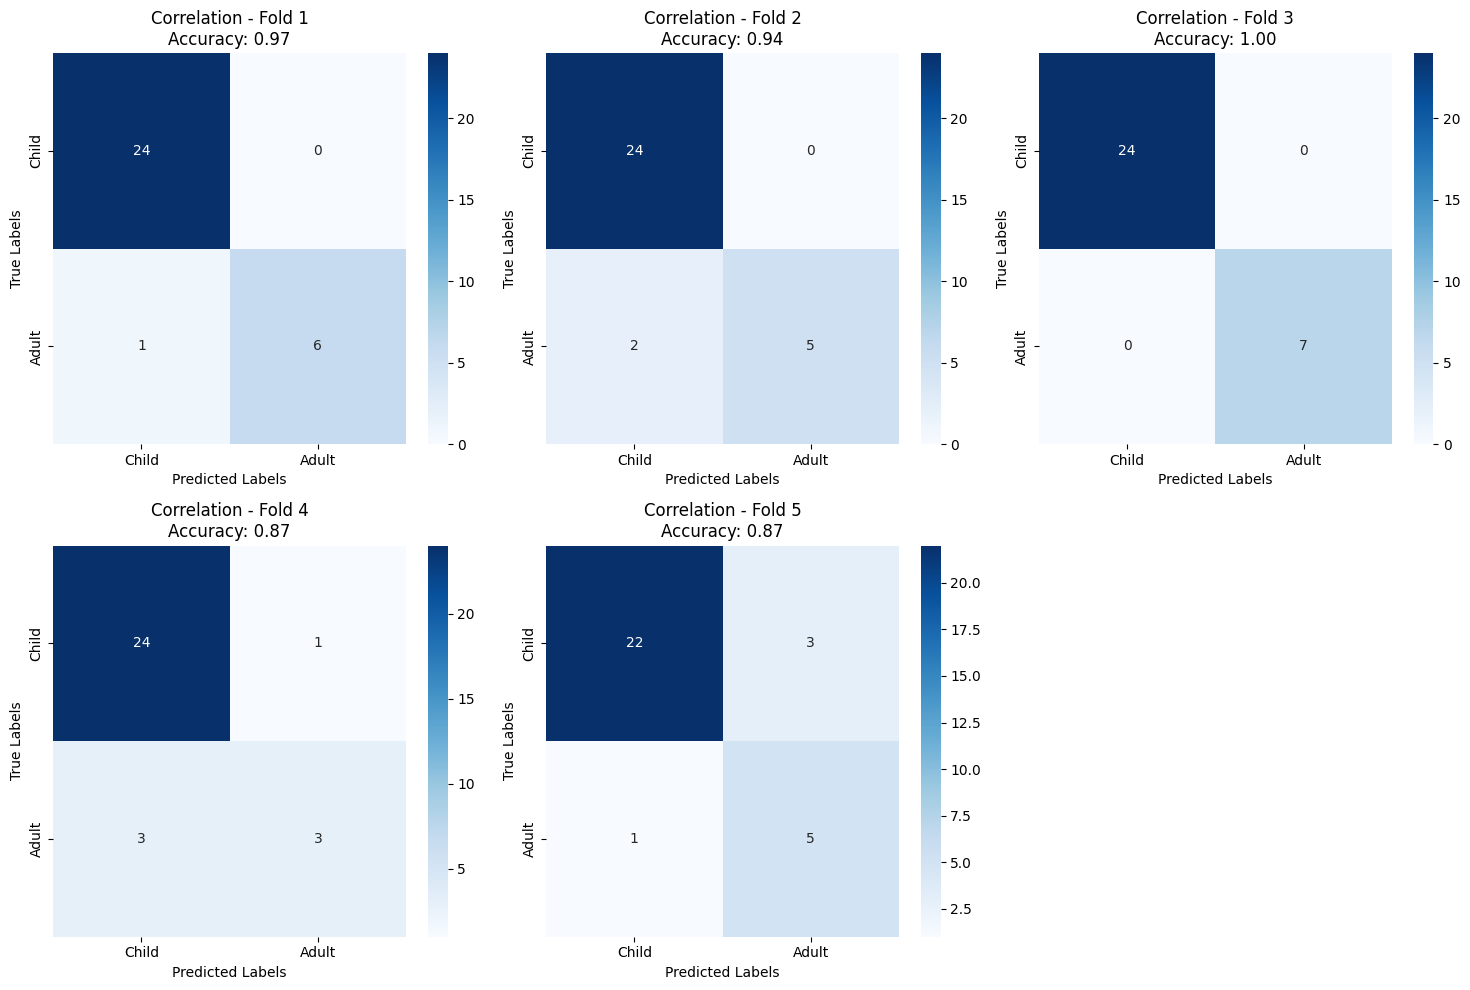

✅ Average Accuracy for correlation: 0.9290

🔍 Evaluating: PARTIAL CORRELATION


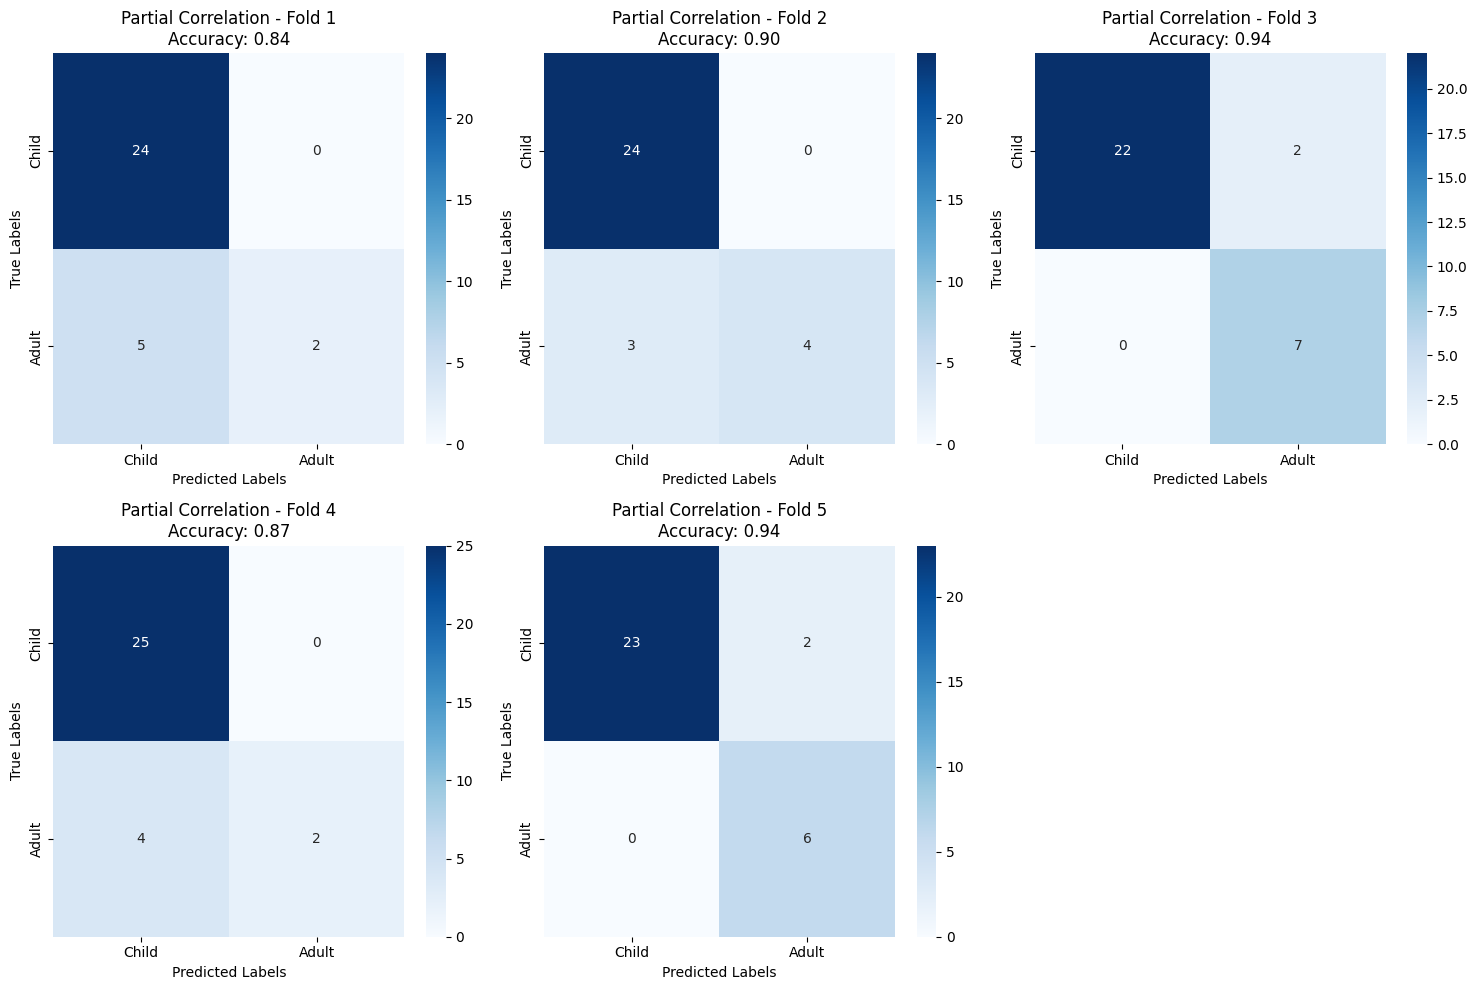

✅ Average Accuracy for partial correlation: 0.8968

🔍 Evaluating: TANGENT


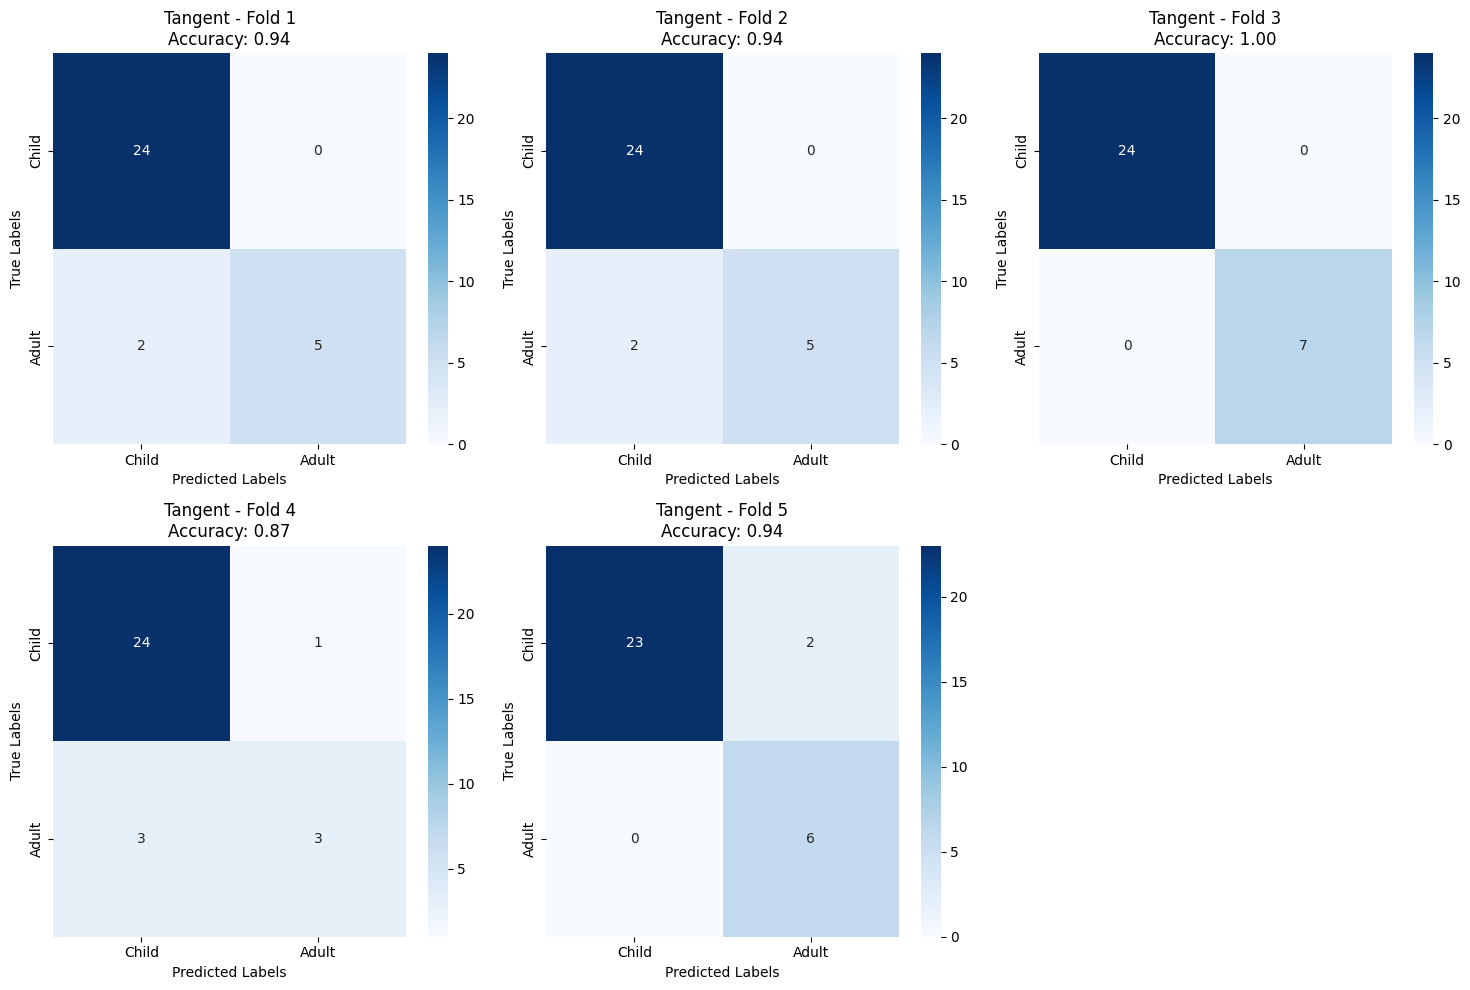

✅ Average Accuracy for tangent: 0.9355


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Evaluating: {kind.upper()}")
    X = upper_triangle_features[kind] #x is the feature matrix (155x741)
    y = labels #target labels

    svm = LinearSVC(C=1.0, max_iter=10000) #initialize svc with regularization strength 1.0
    skf = StratifiedKFold(n_splits=5) #set up stratified CV

    fold = 1
    accuracies = []

    plt.figure(figsize=(15, 10))

    for train_index, test_index in skf.split(X, y): #for each fold split dataset to training and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #train and predict
        svm.fit(X_train, y_train) 
        y_pred = svm.predict(X_test)

        acc = accuracy_score(y_test, y_pred) #percentage of correct predictions
        cm = confusion_matrix(y_test, y_pred)
        accuracies.append(acc)

        plt.subplot(2, 3, fold)
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", 
                    xticklabels=['Child', 'Adult'], 
                    yticklabels=['Child', 'Adult'])
        plt.title(f'{kind.title()} - Fold {fold}\nAccuracy: {acc:.2f}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')

        fold += 1

    plt.tight_layout()
    plt.show()

    print(f"✅ Average Accuracy for {kind}: {np.mean(accuracies):.4f}")


# Updated SVC with class_weight="balanced"


🔍 Evaluating: CORRELATION


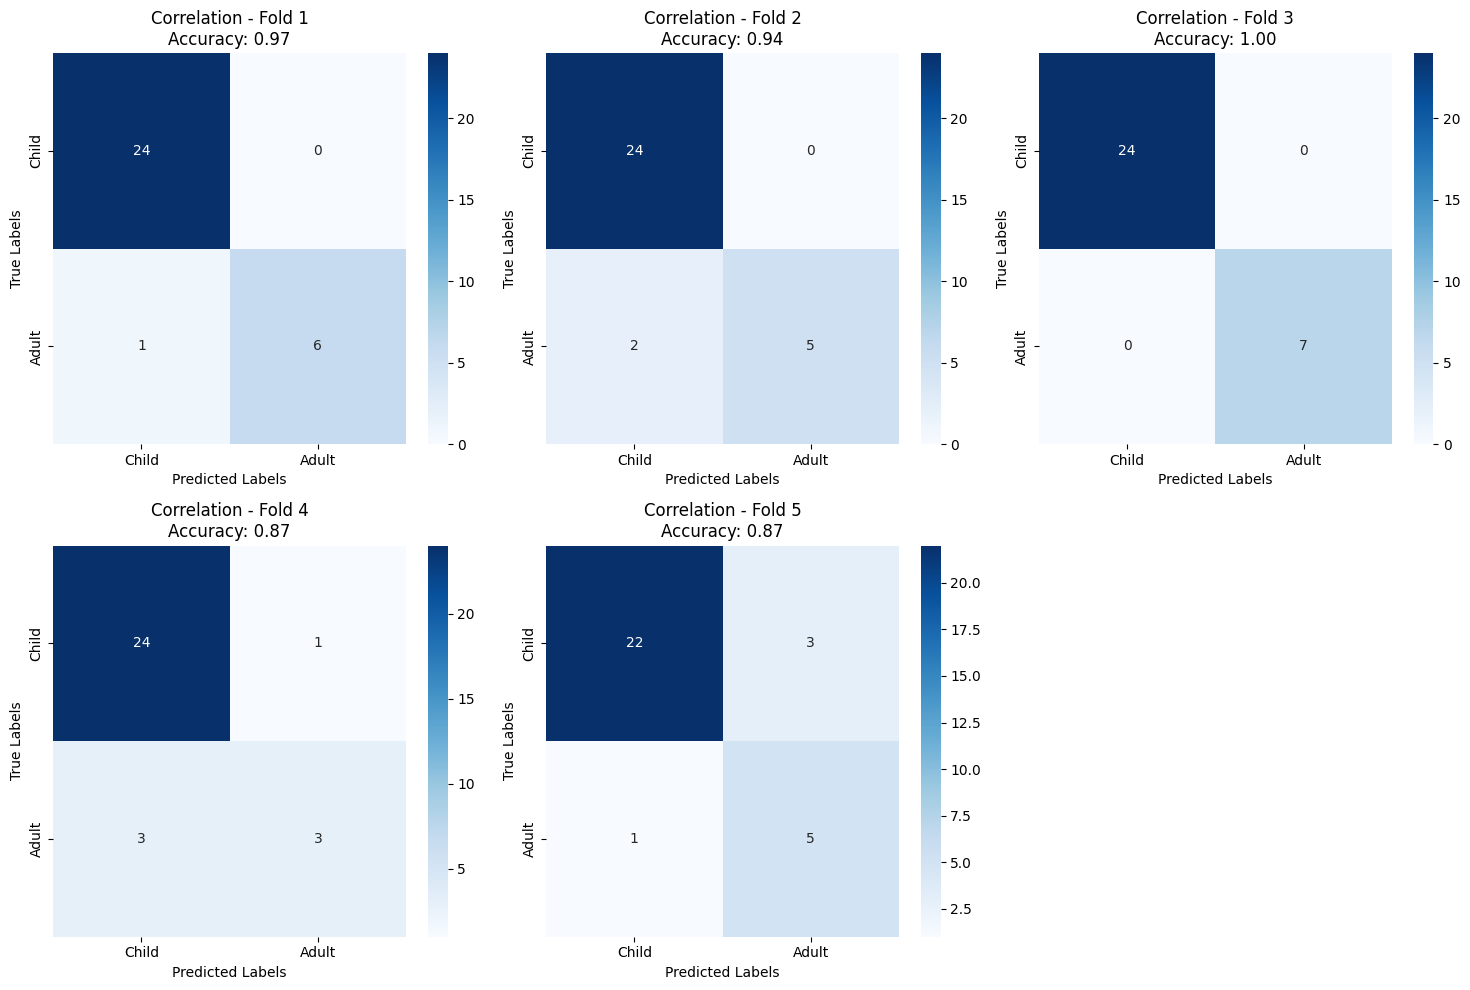

✅ Average Accuracy for correlation: 0.9290

🔍 Evaluating: PARTIAL CORRELATION


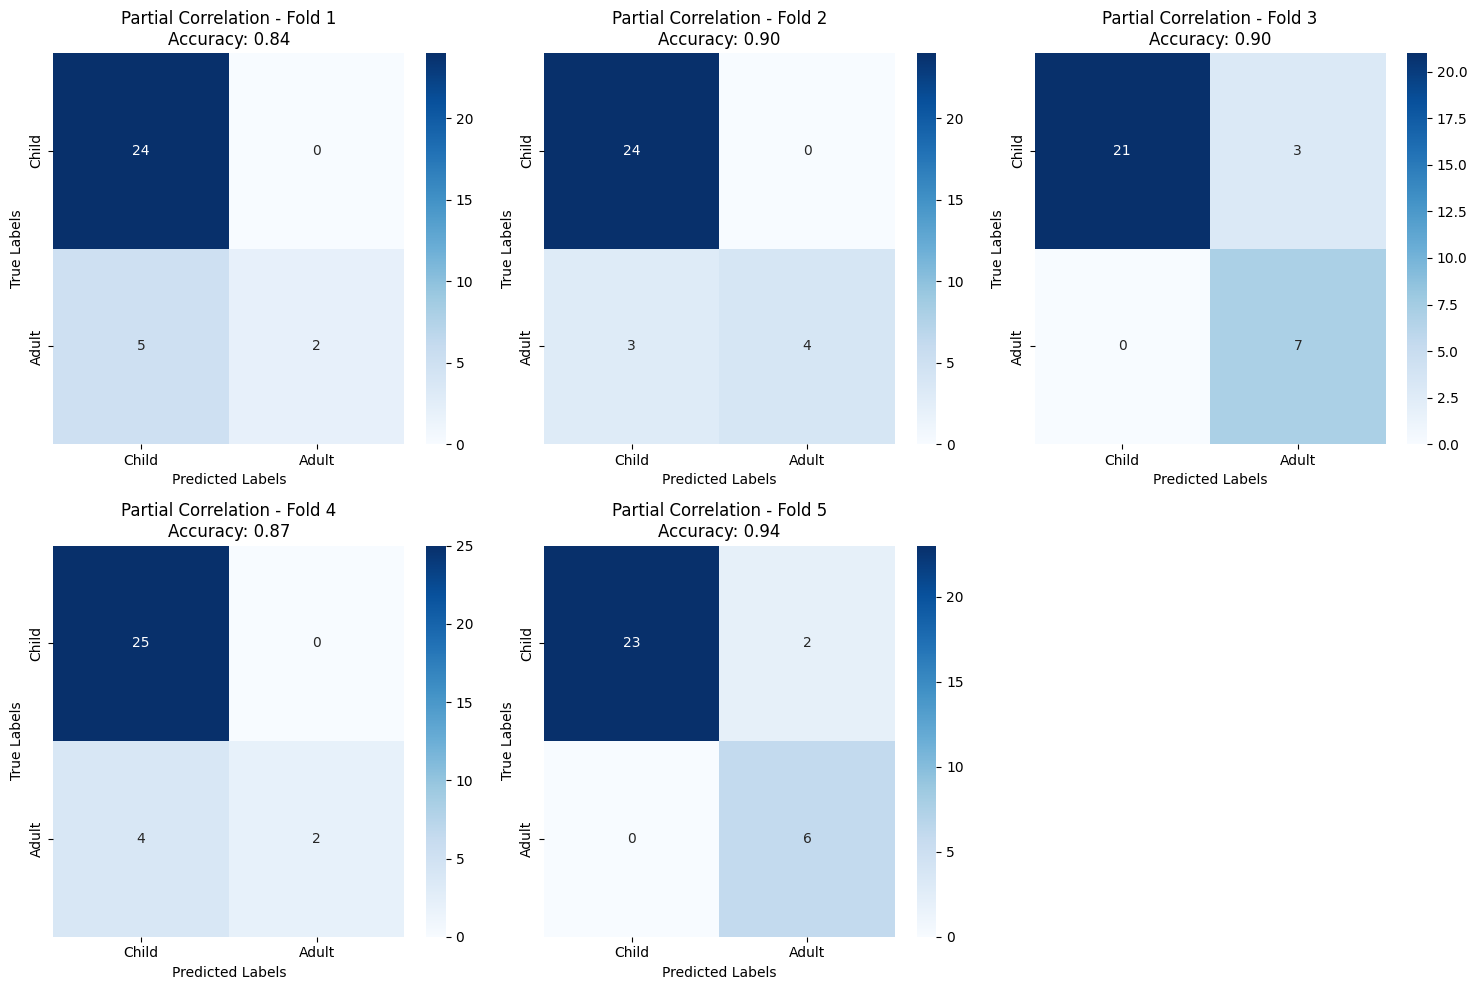

✅ Average Accuracy for partial correlation: 0.8903

🔍 Evaluating: TANGENT


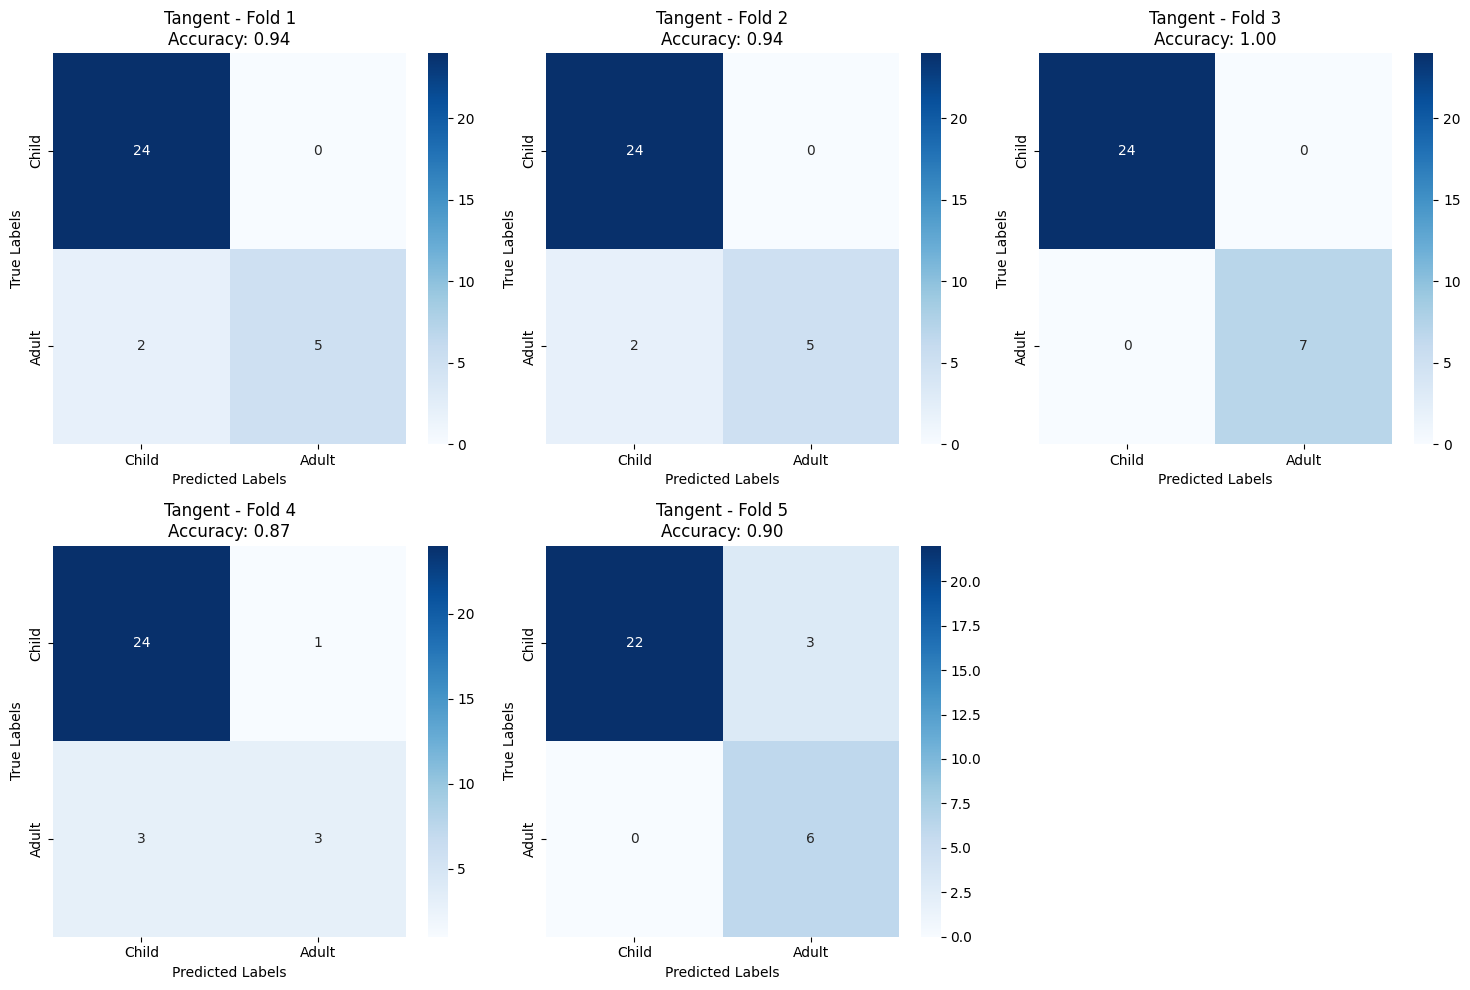

✅ Average Accuracy for tangent: 0.9290


In [5]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Evaluating: {kind.upper()}")
    X = upper_triangle_features[kind]
    y = labels

    svm = LinearSVC(C=1.0, class_weight="balanced", max_iter=10000) #add class_weight balanced
    skf = StratifiedKFold(n_splits=5)

    fold = 1
    accuracies = []

    plt.figure(figsize=(15, 10))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train model
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        accuracies.append(acc)

        # Plot confusion matrix
        plt.subplot(2, 3, fold)
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                    xticklabels=['Child', 'Adult'],
                    yticklabels=['Child', 'Adult'])
        plt.title(f"{kind.title()} - Fold {fold}\nAccuracy: {acc:.2f}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")

        fold += 1

    plt.tight_layout()
    plt.show()

    print(f"✅ Average Accuracy for {kind}: {np.mean(accuracies):.4f}")


## Random Oversampler


🔍 Evaluating: CORRELATION


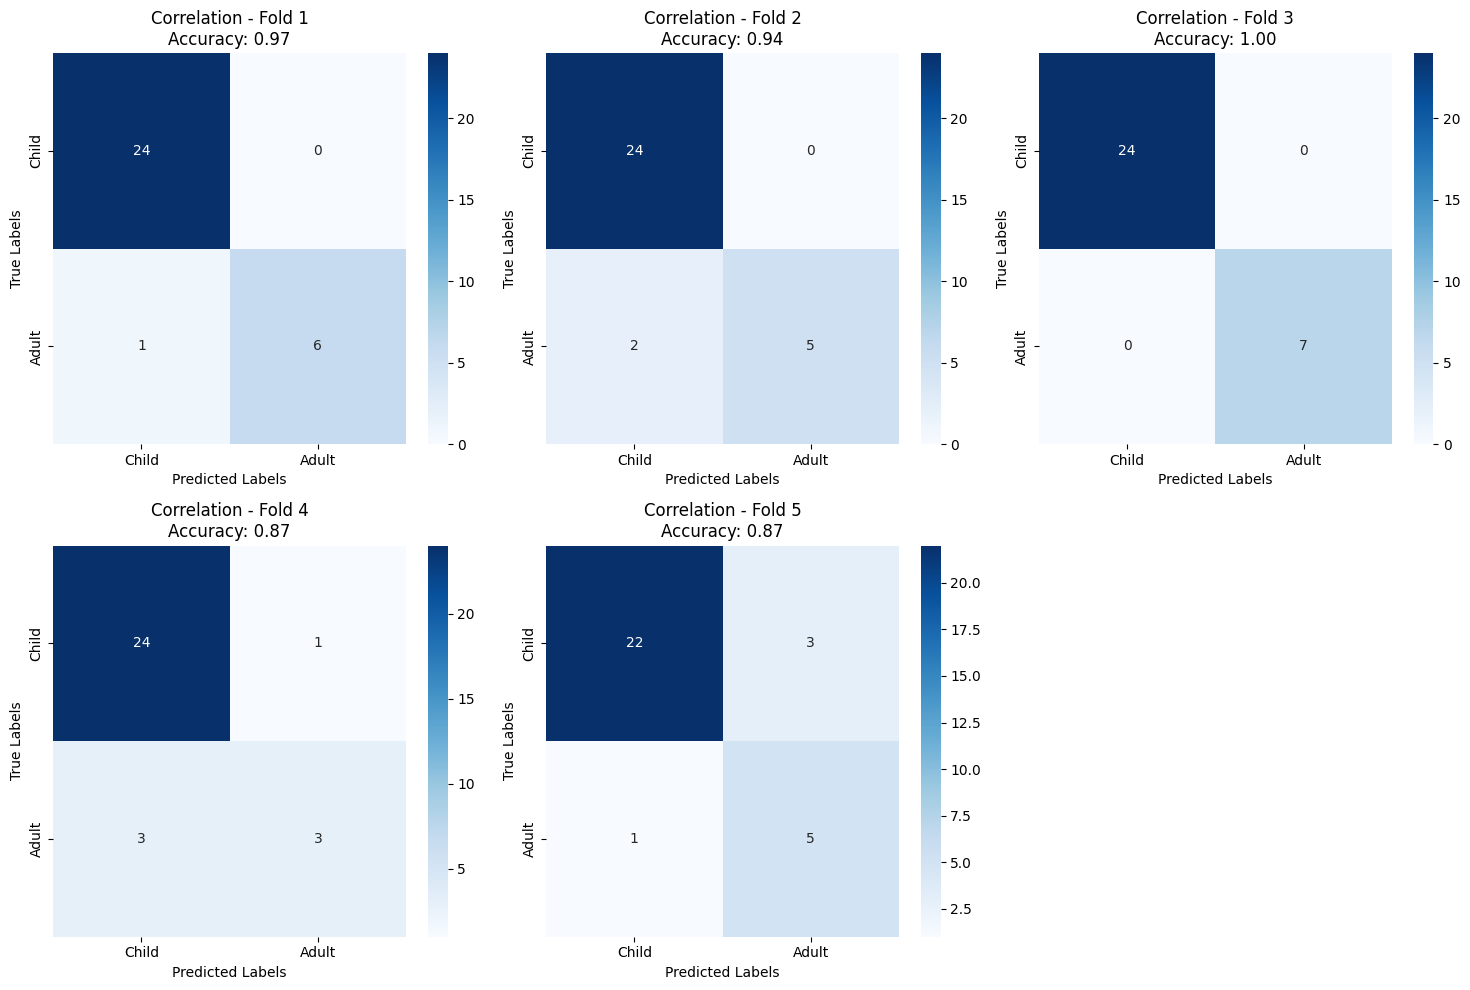

✅ Average Accuracy for correlation: 0.9290

🔍 Evaluating: PARTIAL CORRELATION


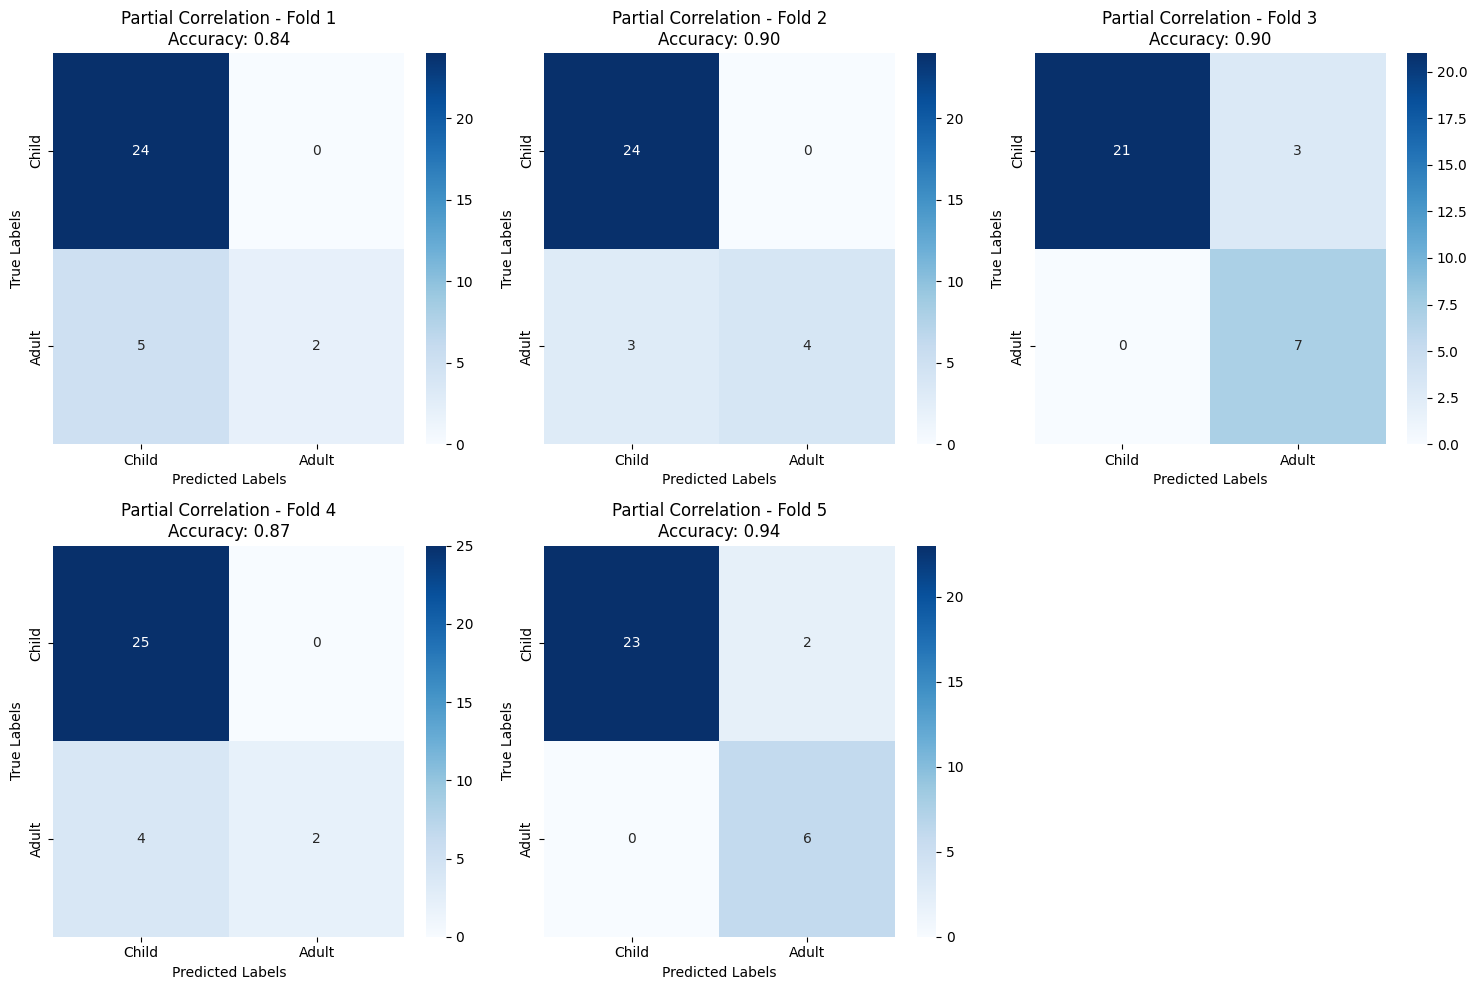

✅ Average Accuracy for partial correlation: 0.8903

🔍 Evaluating: TANGENT


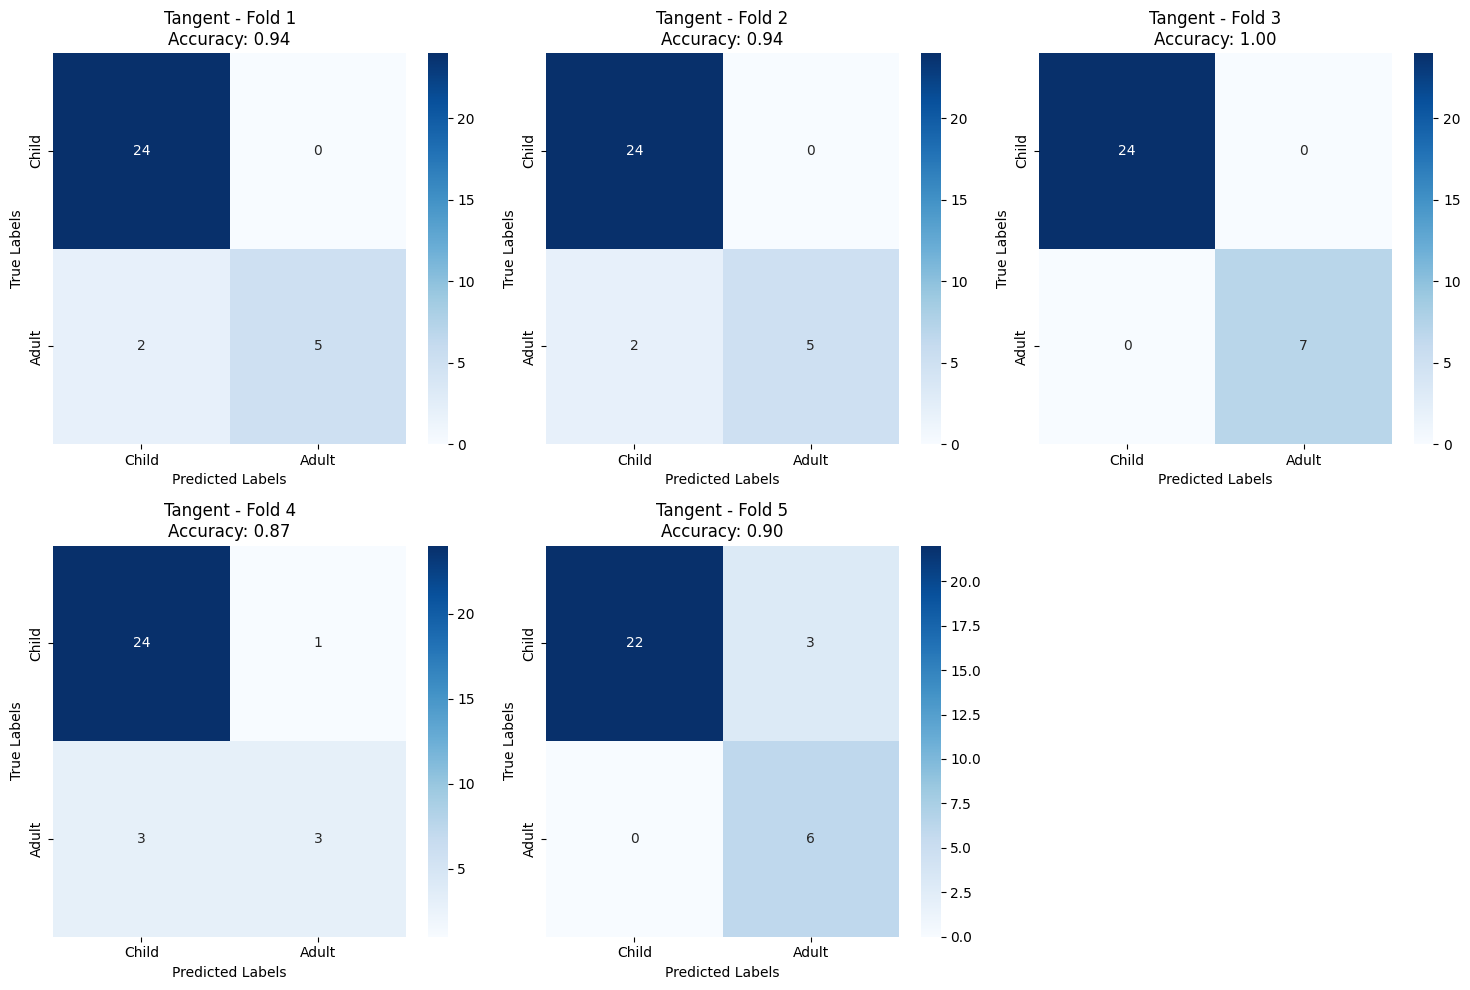

✅ Average Accuracy for tangent: 0.9290


In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Evaluating: {kind.upper()}")
    X = upper_triangle_features[kind]
    y = labels

    svm = LinearSVC(C=1.0, class_weight="balanced", max_iter=10000)
    skf = StratifiedKFold(n_splits=5)

    fold = 1
    accuracies = []

    plt.figure(figsize=(15, 10))

    for train_index, test_index in skf.split(X, y):  #for each fold split dataset to training and test
        X_train, X_test = X[train_index], X[test_index]  
        y_train, y_test = y[train_index], y[test_index]

        # 🧪 Oversample the minority class in training data
        ros = RandomOverSampler(random_state=42) #duplicate minority class in training set (after splitting)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

        # Train on oversampled data
        svm.fit(X_train_resampled, y_train_resampled)
        y_pred = svm.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        accuracies.append(acc)

        # Plot confusion matrix
        plt.subplot(2, 3, fold)
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                    xticklabels=['Child', 'Adult'],
                    yticklabels=['Child', 'Adult'])
        plt.title(f"{kind.title()} - Fold {fold}\nAccuracy: {acc:.2f}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")

        fold += 1

    plt.tight_layout()
    plt.show()

    print(f"✅ Average Accuracy for {kind}: {np.mean(accuracies):.4f}")


# NON LINEAR

## RBF Kernel SVM + Oversampling + 5-Fold CV


🔍 Evaluating: CORRELATION


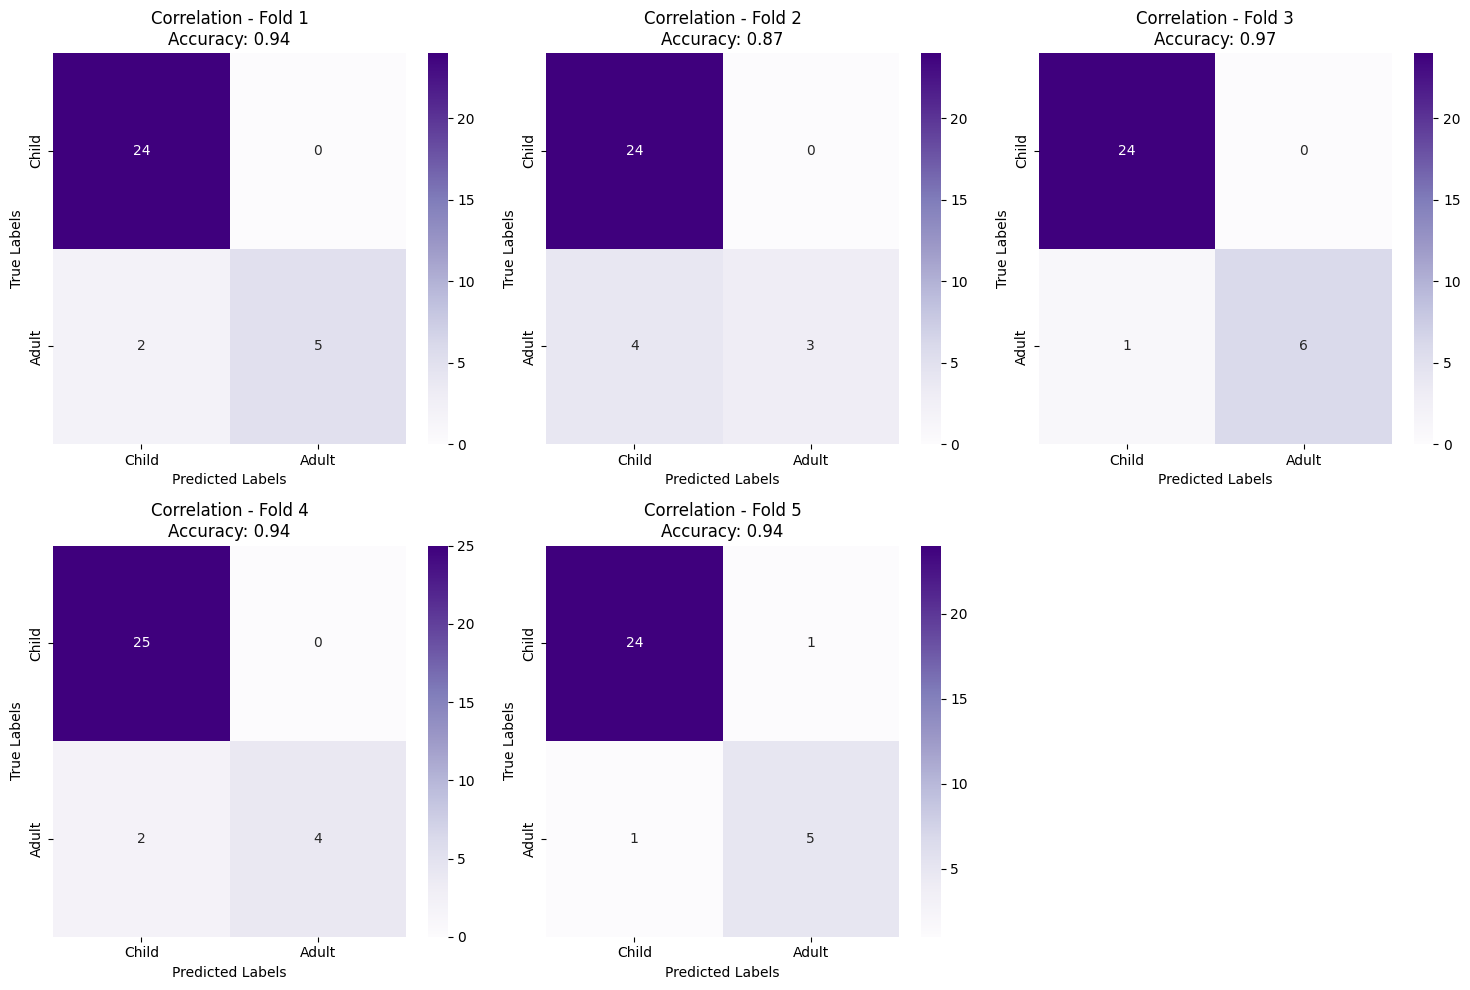

✅ Average Accuracy for correlation: 0.9290

🔍 Evaluating: PARTIAL CORRELATION


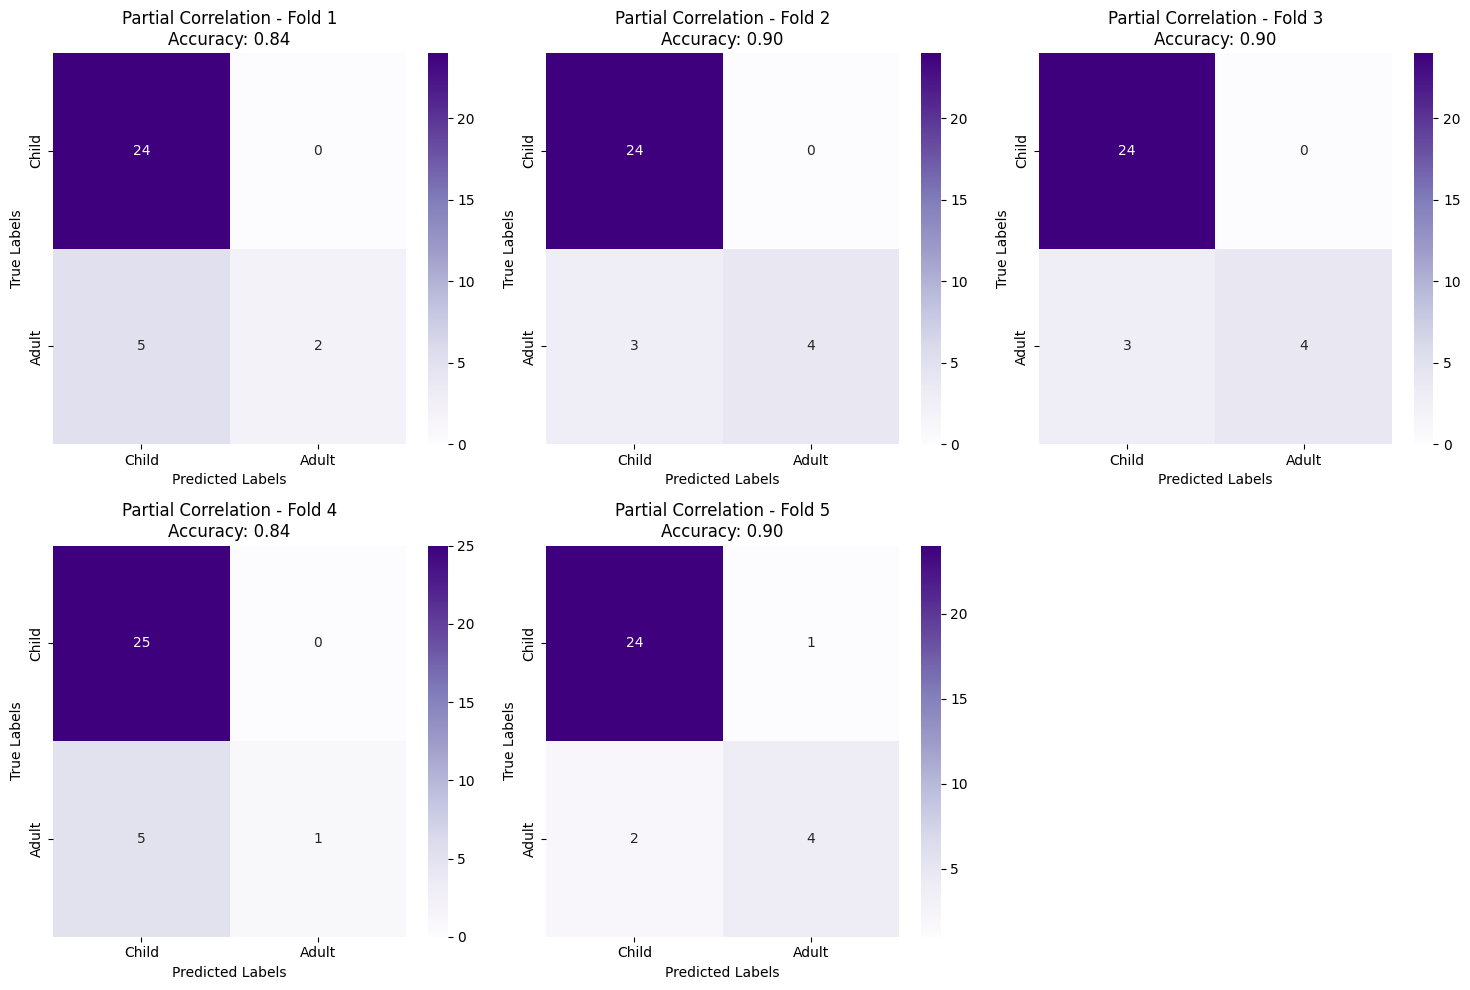

✅ Average Accuracy for partial correlation: 0.8774

🔍 Evaluating: TANGENT


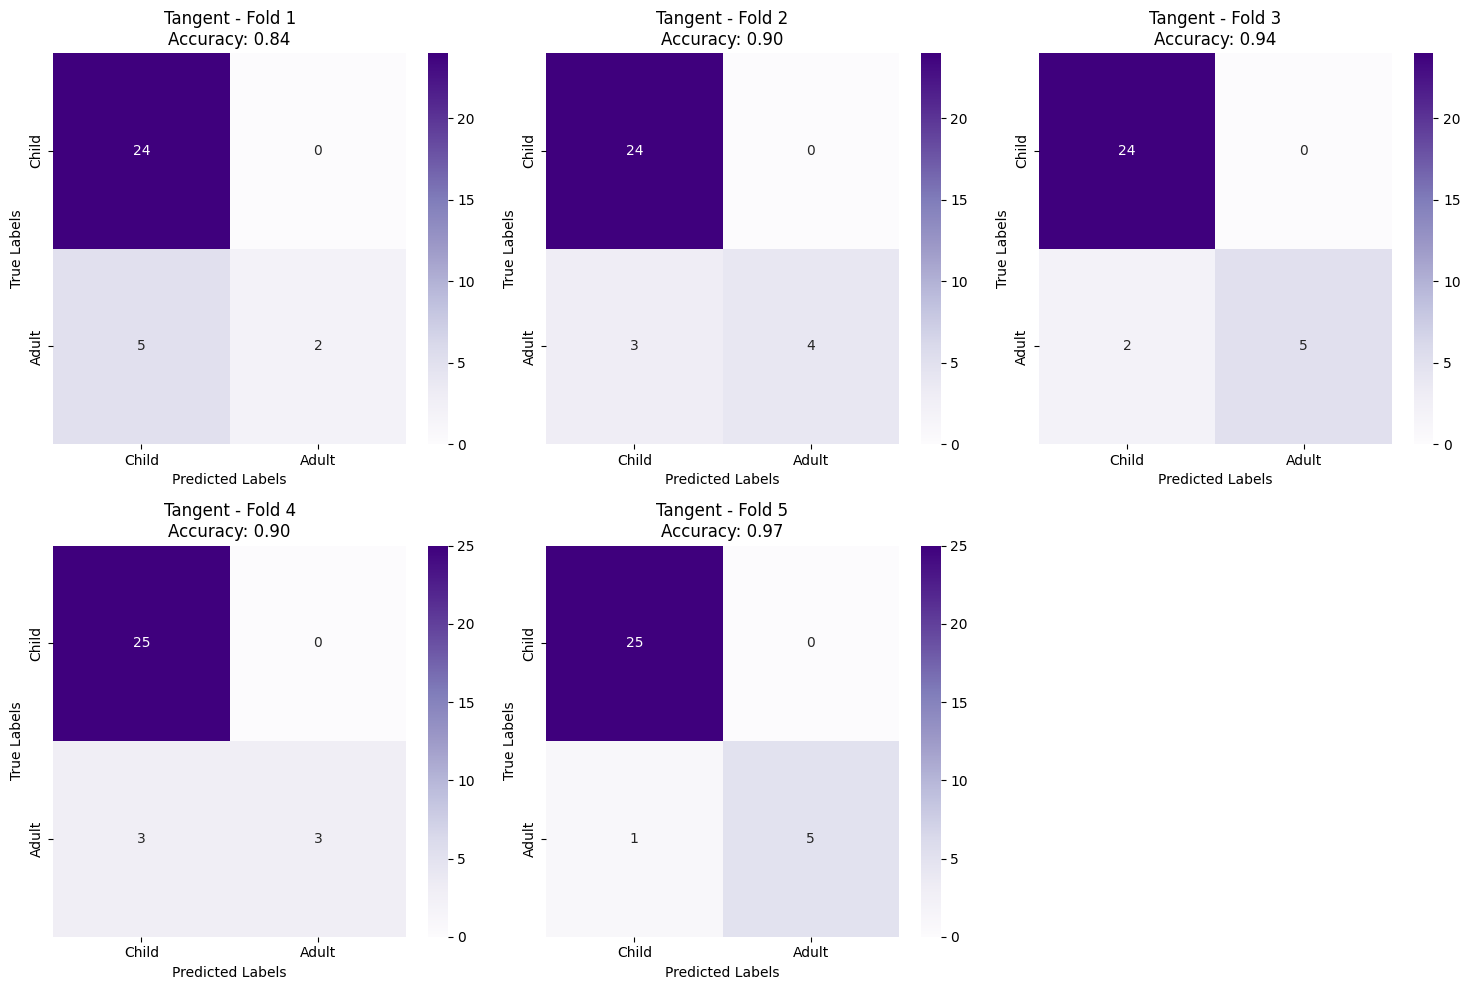

✅ Average Accuracy for tangent: 0.9097


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Evaluating: {kind.upper()}")
    X = upper_triangle_features[kind]
    y = labels

    svc = SVC(kernel='rbf', C=1.0, class_weight='balanced') #initialize rbf kernel
    skf = StratifiedKFold(n_splits=5)

    fold = 1
    accuracies = []

    plt.figure(figsize=(15, 10))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Oversample the minority class in training data
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

        # Train model
        svc.fit(X_train_resampled, y_train_resampled)
        y_pred = svc.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        accuracies.append(acc)

        # Plot confusion matrix
        plt.subplot(2, 3, fold)
        sns.heatmap(cm, annot=True, cmap="Purples", fmt="d",
                    xticklabels=['Child', 'Adult'],
                    yticklabels=['Child', 'Adult'])
        plt.title(f"{kind.title()} - Fold {fold}\nAccuracy: {acc:.2f}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")

        fold += 1

    plt.tight_layout()
    plt.show()

    print(f"✅ Average Accuracy for {kind}: {np.mean(accuracies):.4f}")


## RBF SVM with Hyperparameter Tuning

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔎 Tuning hyperparameters for: {kind.upper()}")
    X = upper_triangle_features[kind]
    y = labels

    # Define hyperparameters
    C_values = [0.1, 1, 10, 100] #C controls the tradeoff between misclassification and margin width
    gamma_values = [0.001, 0.01, 0.1, 1] #controls how far each training example influences the decision boundary 

    best_score = 0 #track best records
    best_params = None

    for C in C_values: #loop through each combo of C and gamma to find highest accuracy
        for gamma in gamma_values:
            svc = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
            skf = StratifiedKFold(n_splits=5)
            accuracies = []
            
            #loop through the folds 
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                ros = RandomOverSampler(random_state=42) #handle class imbalance
                X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
      
                #train model on resampled, balanced training set and tested on original test fold
                svc.fit(X_resampled, y_resampled)
                y_pred = svc.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                accuracies.append(acc)

            avg_acc = np.mean(accuracies)
            print(f"C={C}, gamma={gamma} → Avg Accuracy: {avg_acc:.4f}")

            if avg_acc > best_score:
                best_score = avg_acc
                best_params = (C, gamma)

    print(f"✅ Best Params for {kind}: C={best_params[0]}, gamma={best_params[1]} | Accuracy: {best_score:.4f}")



🔎 Tuning hyperparameters for: CORRELATION
C=0.1, gamma=0.001 → Avg Accuracy: 0.7032
C=0.1, gamma=0.01 → Avg Accuracy: 0.8065
C=0.1, gamma=0.1 → Avg Accuracy: 0.7871
C=0.1, gamma=1 → Avg Accuracy: 0.7871
C=1, gamma=0.001 → Avg Accuracy: 0.8194
C=1, gamma=0.01 → Avg Accuracy: 0.9484
C=1, gamma=0.1 → Avg Accuracy: 0.7871
C=1, gamma=1 → Avg Accuracy: 0.7871
C=10, gamma=0.001 → Avg Accuracy: 0.9484
C=10, gamma=0.01 → Avg Accuracy: 0.9484
C=10, gamma=0.1 → Avg Accuracy: 0.7871
C=10, gamma=1 → Avg Accuracy: 0.7871
C=100, gamma=0.001 → Avg Accuracy: 0.9484
C=100, gamma=0.01 → Avg Accuracy: 0.9484
C=100, gamma=0.1 → Avg Accuracy: 0.7871
C=100, gamma=1 → Avg Accuracy: 0.7871
✅ Best Params for correlation: C=1, gamma=0.01 | Accuracy: 0.9484

🔎 Tuning hyperparameters for: PARTIAL CORRELATION
C=0.1, gamma=0.001 → Avg Accuracy: 0.8452
C=0.1, gamma=0.01 → Avg Accuracy: 0.8581
C=0.1, gamma=0.1 → Avg Accuracy: 0.8645
C=0.1, gamma=1 → Avg Accuracy: 0.7871
C=1, gamma=0.001 → Avg Accuracy: 0.8452
C=1, ga

Final evaluation of RBF SVM model using the best hyperparameters found from the previous tuning step


📊 Final Evaluation for: CORRELATION


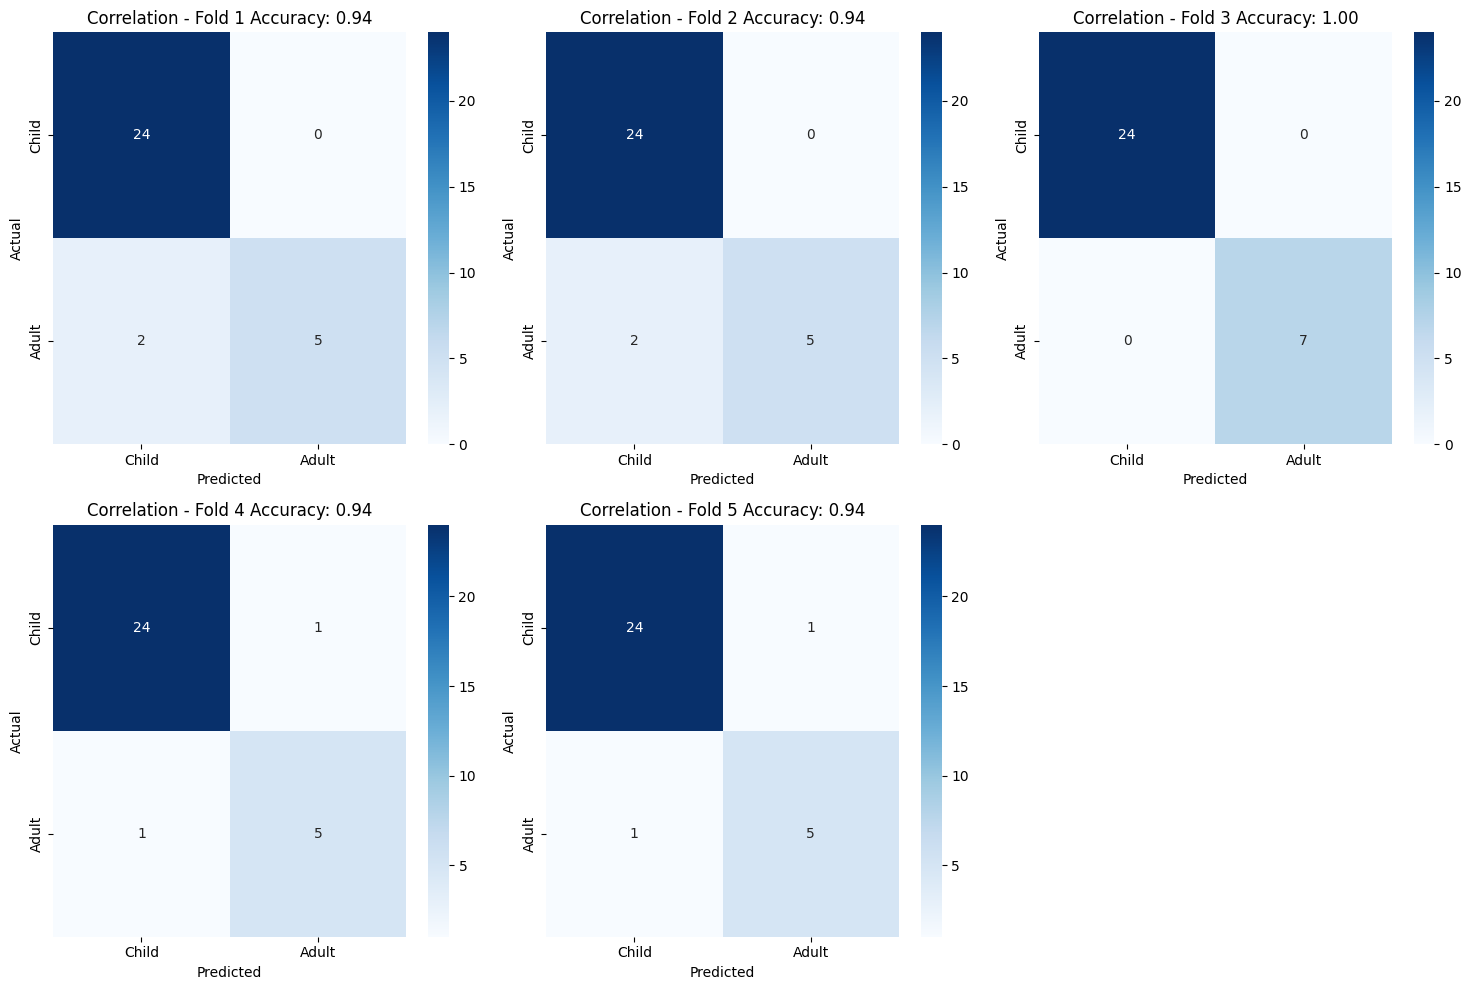

✅ Avg Accuracy for CORRELATION (C=1, gamma=0.01): 0.9484

📊 Final Evaluation for: PARTIAL CORRELATION


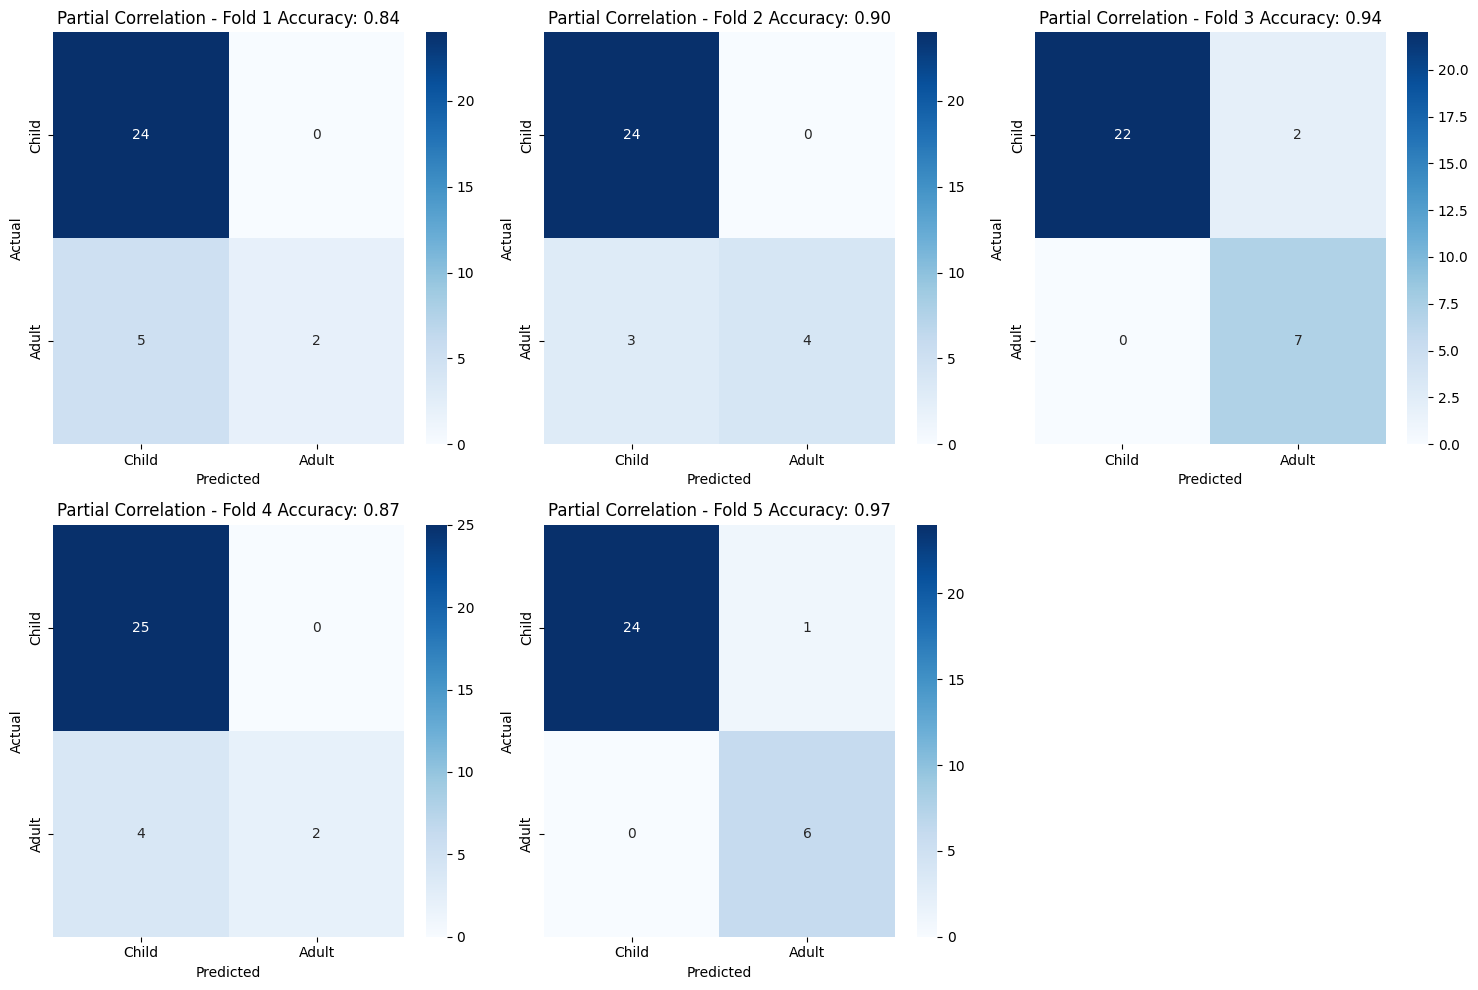

✅ Avg Accuracy for PARTIAL CORRELATION (C=10, gamma=0.01): 0.9032

📊 Final Evaluation for: TANGENT


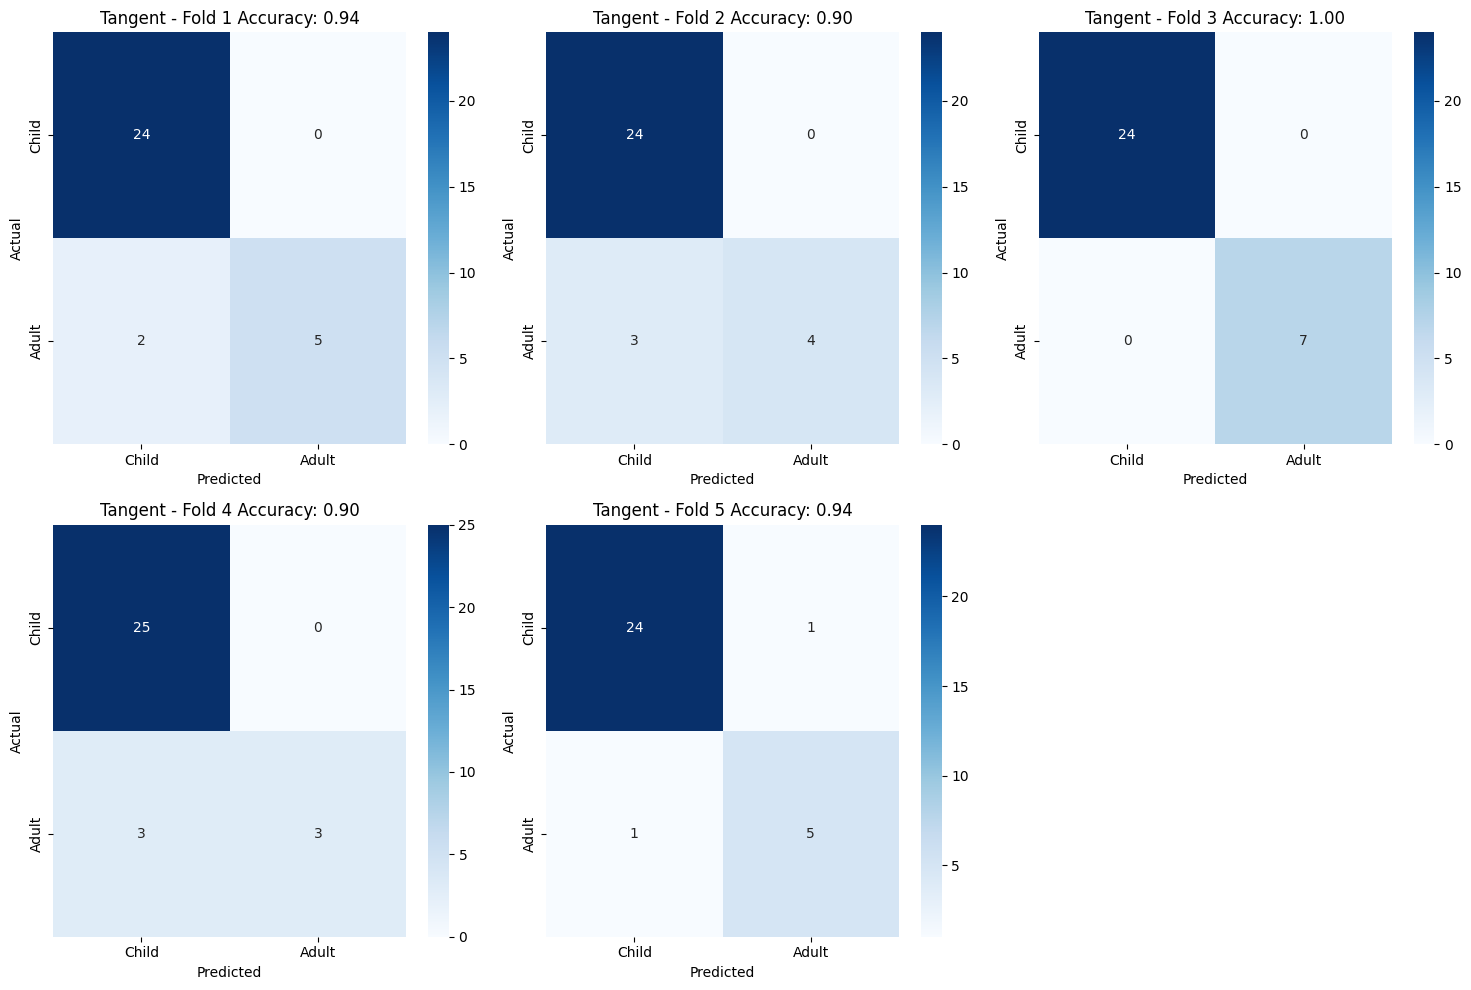

✅ Avg Accuracy for TANGENT (C=100, gamma=0.01): 0.9355


In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

# 🔧 Replace these with your actual best params from tuning
best_params_by_type = {
    "correlation": (1, 0.01),
    "partial correlation": (10, 0.01),
    "tangent": (100, 0.01)
}

for kind in correlation_types:
    print(f"\n📊 Final Evaluation for: {kind.upper()}")
    X = upper_triangle_features[kind]
    y = labels

    C, gamma = best_params_by_type[kind]
    svc = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
    skf = StratifiedKFold(n_splits=5)

    accuracies = []
    fold = 1
    plt.figure(figsize=(15, 10))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

        svc.fit(X_resampled, y_resampled)
        y_pred = svc.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        cm = confusion_matrix(y_test, y_pred)
        plt.subplot(2, 3, fold)
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                    xticklabels=['Child', 'Adult'],
                    yticklabels=['Child', 'Adult'])
        plt.title(f"{kind.title()} - Fold {fold} Accuracy: {acc:.2f}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        fold += 1

    plt.tight_layout()
    plt.show()
    print(f"✅ Avg Accuracy for {kind.upper()} (C={C}, gamma={gamma}): {np.mean(accuracies):.4f}")


### 🔍 Mine vs Nilearn Pipelines — Comparison

#### ✅ What’s Common in Both Pipelines:
- Same dataset: 155 subjects from `fetch_development_fmri(n_subjects=None)`
- Time series extracted using `NiftiMapsMasker` with:
  - `standardize="zscore_sample"`
  - `standardize_confounds=True`
- Correlation matrices (correlation, partial, tangent) computed using `ConnectivityMeasure(...)`
- Correlation matrix shape: (155, 39, 39)
- Used as input to Linear SVM with 5-fold cross-validation

---

#### 🟩 **Lower Triangle Pipeline** (Notebook: `NilearnALLsubjects.ipynb`)
| Feature | Detail |
|--------|--------|
| Vectorization | Done with `vectorize=True` in `ConnectivityMeasure` |
| Triangle used | **Lower triangle** (automatically by nilearn) |
| Feature order | Internal nilearn convention |
| Standardization | Applied inside `ConnectivityMeasure` |
| Label source | `pooled_subjects` and `groups` from `development_dataset` |

---

#### 🟦 **Upper Triangle Pipeline** (Notebook: `LinearAndNonLinearSVC.ipynb`)
| Feature | Detail |
|--------|--------|
| Vectorization | Manual using `np.triu_indices(n, k=1)` |
| Triangle used | **Upper triangle** (excluding diagonal) |
| Feature order | Manual NumPy ordering |
| Standardization | ❌ Not shown |
| Label source | Loaded from `subject_labels.npy` |

---

### ⚠️ Key Differences That Explain Accuracy Gap

| Issue | Impact |
|-------|--------|
| 🧩 Feature Order | Upper and lower triangles extract values in different **orders**, so even if values are similar, the classifier sees them as different connections. |
| 📏 Standardization | `ConnectivityMeasure(..., vectorize=True)` standardizes by default. my upper triangle pipeline likely missed z-score scaling across subjects → affects SVM decision boundary. |


---

### ✅ Final Notes

To make the upper triangle pipeline exactly equivalent:
- We can use the same **feature extraction order**:
  ```python
  from nilearn.connectome import sym_matrix_to_vec
  features = np.array([sym_matrix_to_vec(m, discard_diagonal=True) for m in matrices])
